# Logistic Regression Titanic Dataset

The goal is to predict survival of passengers traveling in RMS Titanic using Logistic Regression.

## Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

All the necessary libraries are imported and now we move on to importing and cleaning the data.

## Data Cleaning

In [2]:
df = pd.read_csv("titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.shape

(891, 12)

There are `891` rows and `12` columns in the dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


All the columns seem to have correct datatypes.

In [5]:
df.isna().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

`Cabin` has the most number of missing values. However we can drop that column safely as having a cabin indicates the person was from 1st Class and we already have a column for that.

In [6]:
df.drop(['Cabin'], axis=1, inplace=True)

In [7]:
df.isna().sum().sort_values(ascending=False)

Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

Now `Embarked` column as `2` missing values but since it is a categorical column we insert the mode of the column.

In [8]:
df.Embarked.fillna(df.Embarked.mode()[0], inplace=True)
df.isna().sum().sort_values(ascending=False)

Age            177
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
dtype: int64

`Age` is a numerical column therefore we have two choices : either use the `mean` or the `median` to replace the missing values. But our choice will depend on the distribution of the `Age` column ie. whether it is normal or not.

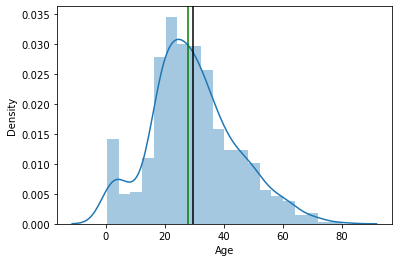

0.38910778230082704


In [9]:
sns.distplot(df.Age)
plt.axvline(df.Age.mean(), color='black')
plt.axvline(df.Age.median(), color='green')
plt.show()
print(df.Age.skew())

With skewness of `0.389` we can say that the distribution is almost normal so we will replace the missing values with the `mean` of the column.

In [10]:
df.Age.fillna(df.Age.mean(), inplace=True)
df.isna().sum().sort_values(ascending=False)

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

We have no missing values and our data is clean. Now we will prepare the data for our model.

## Data Preparation

The `SibSp` and `Parch` columns seem useless on their own. We will combine them to create a new column called `FamilySize`.

In [11]:
df['FamilySize']  = df['SibSp'] + df['Parch'] + 1
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1


We will drop `PassengerId`, `Ticket`, `Name` as it is absurd to imagine these features will play an important role in predicting whether someone survives or not. `SibSp` and `Parch` are dropped because we have created a new feature using them. `Fare` directly won't play a role but it depends on `Pclass` as higher class will have higher fare so we drop it.

In [12]:
df.drop(['PassengerId', 'Ticket', 'Name', 'SibSp', 'Parch', 'Fare'], axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex,Age,Embarked,FamilySize
0,0,3,male,22.0,S,2
1,1,1,female,38.0,C,2
2,1,3,female,26.0,S,1
3,1,1,female,35.0,S,2
4,0,3,male,35.0,S,1


We will now use One Hot Encoding to convert our categorical columns into numerical columns.

In [13]:
df = pd.get_dummies(df, columns=['Pclass', 'Embarked', 'Sex'], drop_first=True)
df.head()

,Survived,Age,FamilySize,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,2,0,1,0,1,1
1,1,38.0,2,0,0,0,0,0
2,1,26.0,1,0,1,0,1,0
3,1,35.0,2,0,0,0,1,0
4,0,35.0,1,0,1,0,1,1


`Age` column is not in the same scale as the rest of our data so to make the training process smooth we will scale the feature. The scaling technique will depend on the distribution of the data.

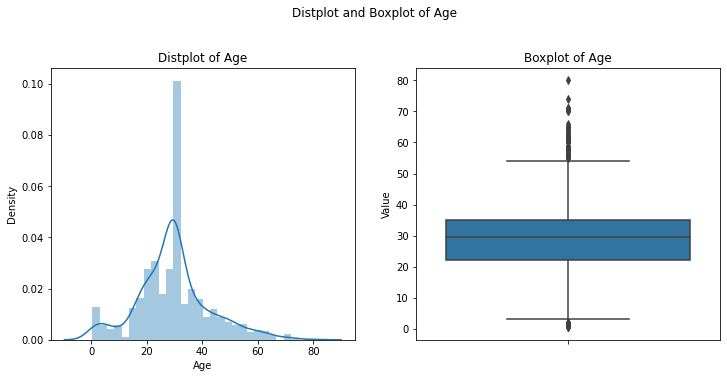

In [14]:
# Set up the figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Draw the distplot in the left subplot
plt.subplot(1, 2, 1)
sns.distplot(df['Age'])
plt.title('Distplot of Age')

# Draw the boxplot in the right subplot
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Age'])
plt.title('Boxplot of Age')

# Set common y-axis label for both subplots
plt.suptitle('Distplot and Boxplot of Age', y=1.05)
plt.ylabel('Value')

# Show the plot
plt.show()

In [15]:
print(df['Age'].skew())

0.4344880940129925


With skewness of `0.434` the data can be assumed as being close to normally distributed so we will use `StandardScaler`.

In [16]:
# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to your data
scaler.fit(df[['Age']])

# Transform the data
df['Age'] = scaler.transform(df[['Age']])

In [17]:
df[['Age']].describe()

,Age
count,8.910000e+02
mean,2.232906e-16
std,1.000562e+00
min,-2.253155e+00
25%,-5.924806e-01
50%,0.000000e+00
75%,4.079260e-01
max,3.870872e+00


The mean of the column is `0` with standard deviation as `1`.

In [18]:
df.head()

,Survived,Age,FamilySize,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,-0.592481,2,0,1,0,1,1
1,1,0.638789,2,0,0,0,0,0
2,1,-0.284663,1,0,1,0,1,0
3,1,0.407926,2,0,0,0,1,0
4,0,0.407926,1,0,1,0,1,1


Our data is now ready to be used for model training.

## Model Development

`Survived` is our dependent feature so we will denote it with `y`.

In [19]:
y = df.pop('Survived')
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

The rest of the features will be our independent variable. We will denote them with `X`.

In [20]:
X = df
X.head()

,Age,FamilySize,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,-0.592481,2,0,1,0,1,1
1,0.638789,2,0,0,0,0,0
2,-0.284663,1,0,1,0,1,0
3,0.407926,2,0,0,0,1,0
4,0.407926,1,0,1,0,1,1


Now we will check for highly correlated columns.

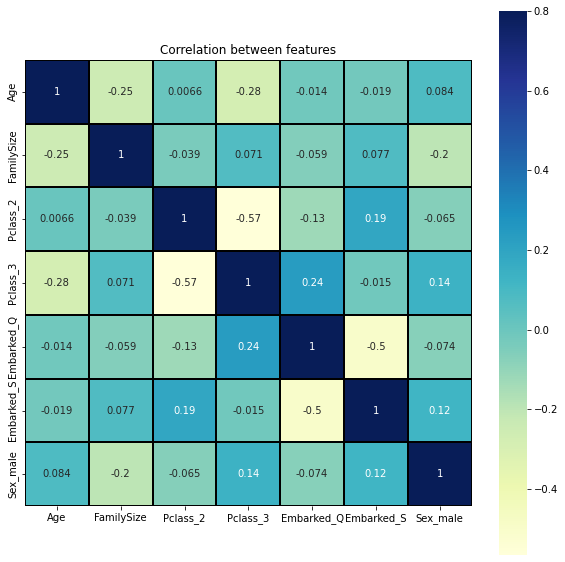

In [21]:
corr = X.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, vmax=.8, linewidth=.01, square=True, annot=True, linecolor='black', cmap='YlGnBu')
plt.title("Correlation between features")
plt.show()

Nothing alarming. We will verify this using VIF.

In [22]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,Embarked_S,4.30
3,Pclass_3,3.73
6,Sex_male,2.62
1,FamilySize,2.15
2,Pclass_2,1.86
4,Embarked_Q,1.47
0,Age,1.16


All of the values are below `5` so we are good to go. Now we will divide our data into training and testing sets.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [24]:
X_train.shape

(712, 7)

In [25]:
X_test.shape

(179, 7)

In [26]:
y_train.shape

(712,)

In [27]:
y_test.shape

(179,)

Now we will check if our dependent variable has more observations of one category than the other ie. class imbalance.

In [28]:
y.value_counts(normalize = True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

We can observe that the majority of the labels are from class 0 and only a few are from class 1. If we use this distribution to develop our model, it may become biased towards predicting the majority class. As a result, we must consider class imbalance when developing our Logistic Regression model.

There are a variety of approaches to dealing with class imbalance, such as increasing minority class samples or decreasing majority class samples to ensure that both classes have the same distribution.

Because we’re using the Scikit-learn machine library to create the model, it has a logistic regression implementation that supports class weighting. We will use the inbuilt parameter “class_weight” while creating an instance of the Logistic Regression model.

Both the majority and minority classes will be given separate weights. During the training phase, the weight differences will influence the classification of the classes.

The purpose of adding class weights is to penalize the minority class for misclassification by setting a higher class weight while decreasing the weight for the majority class.

In [29]:
lr_basemodel =LogisticRegression(class_weight = {0:0.45,1:0.55})

lr_basemodel.fit(X_train,y_train)

LogisticRegression(class_weight={0: 0.45, 1: 0.55})

We set the weights as `0.45` and `0.55` for `0` and `1` respectively.

In [30]:
y_pred_train = lr_basemodel.predict(X_train)
y_pred_test = lr_basemodel.predict(X_test)

In [31]:
# Calculate accuracy
accuracy = accuracy_score(y_train, y_pred_train)

# Calculate precision
precision = precision_score(y_train, y_pred_train)

# Calculate recall
recall = recall_score(y_train, y_pred_train)

# Calculate F1 score
f1 = f1_score(y_train, y_pred_train)

# Create a DataFrame to store the results
results_df = pd.DataFrame({'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],'Score': [accuracy, f1, precision, recall]})
results_df

,Metric,Score
0,Accuracy,0.800562
1,F1 Score,0.726923
2,Precision,0.747036
3,Recall,0.707865


Our model did a great job on training set. We will check the metrics of testing set as well to see if our model has overfitted.

In [32]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_test)

# Calculate precision
precision = precision_score(y_test, y_pred_test)

# Calculate recall
recall = recall_score(y_test, y_pred_test)

# Calculate F1 score
f1 = f1_score(y_test, y_pred_test)

# Create a DataFrame to store the results
results_df = pd.DataFrame({'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],'Score': [accuracy, f1, precision, recall]})
results_df

,Metric,Score
0,Accuracy,0.804469
1,F1 Score,0.751773
2,Precision,0.803030
3,Recall,0.706667


Similar metrics here as well. Hence our model is a perfect fit and works well.

## Hyperparameter Optimization

Up to this point, we created a logistic regression model using default parameters. Now let’s increase model performance and evaluate it again after tuning hyperparameters of the model.

Hyperparameter tuning can be done using algorithms like Grid Search or Random Search.

In [33]:
weights = np.linspace(0.0,0.99,50)

# Define the hyperparameter grid for logistic regression
param = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 15, 20],
    'fit_intercept': [True, False],
    'solver': ['liblinear', 'saga', 'newton-cg', 'lbfgs'],
    "class_weight": [{0:x ,1:1.0 -x} for x in weights]
}

# Create a logistic regression model
logreg = LogisticRegression()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator = logreg, param_grid = param, scoring='f1', cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 15, 20],
                         'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.02020408163265306,
                                           1: 0.9797959183673469},
                                          {0: 0.04040816326530612,
                                           1: 0.9595918367346938},
                                          {0: 0.06061224489795918,
                                           1: 0.9393877551020409},
                                          {0: 0.08081632653061224,
                                           1: 0.9191836734693878},
                                          {0: 0.1010204081632653,
                                           1: 0.8989795918367347},
                                          {0: 0.1212...
                                           1: 0.5151020408163265},
                                       

In [34]:
print(grid_search.best_params_)

{'C': 20, 'class_weight': {0: 0.38387755102040816, 1: 0.6161224489795918}, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}


These are the best hyperparameters for our data. Now we will use these parameters to create the model.

In [35]:
best_model = LogisticRegression(C = 20, 
                                class_weight = {0: 0.38387755102040816, 1: 0.6161224489795918}, 
                                fit_intercept = True, 
                                penalty = 'l1',
                                solver = 'liblinear')
best_model.fit(X_train,y_train)

LogisticRegression(C=20,
                   class_weight={0: 0.38387755102040816, 1: 0.6161224489795918},
                   penalty='l1', solver='liblinear')

In [36]:
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

Checking metrics of training set.

In [37]:
# Calculate accuracy
accuracy = accuracy_score(y_train, y_pred_train)

# Calculate precision
precision = precision_score(y_train, y_pred_train)

# Calculate recall
recall = recall_score(y_train, y_pred_train)

# Calculate F1 score
f1 = f1_score(y_train, y_pred_train)

# Create a DataFrame to store the results
results_df = pd.DataFrame({'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],'Score': [accuracy, f1, precision, recall]})
results_df

,Metric,Score
0,Accuracy,0.796348
1,F1 Score,0.741533
2,Precision,0.707483
3,Recall,0.779026


All the metrics are good. Now we check the same for testing set.

In [38]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_test)

# Calculate precision
precision = precision_score(y_test, y_pred_test)

# Calculate recall
recall = recall_score(y_test, y_pred_test)

# Calculate F1 score
f1 = f1_score(y_test, y_pred_test)

# Create a DataFrame to store the results
results_df = pd.DataFrame({'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],'Score': [accuracy, f1, precision, recall]})
results_df

,Metric,Score
0,Accuracy,0.815642
1,F1 Score,0.778523
2,Precision,0.783784
3,Recall,0.773333


Compared to our previous model this one performs far better. Another metric to validate our result is the ROC curve.

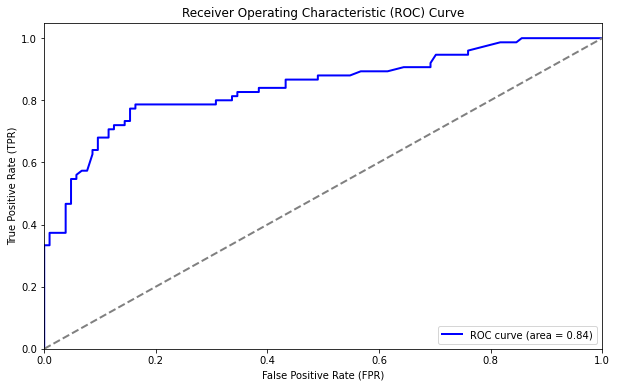

In [39]:
# Predict probabilities for the test data
y_probs = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [40]:
roc_auc_score(y_test, y_pred_test)

0.8097435897435898

The area under ROC curve is `0.84` whereas roc_auc_score is `0.81`. This is due to slight computational differences. Both of the values should be close to `1` and the same is observed.

## Choosing Threshold value

The output of logistic regression is an array of probabilities. By default, if the value is below `0.5` then the predicted class is `0` and `1` otherwise. However according to our use case we can change the threshold for our desired metrics.

In [41]:
pred_val = np.where(best_model.predict_proba(X_test)[:,1] > 0.50, 1, 0)
pred_val

array([1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1])

In [42]:
cutoff_df = pd.DataFrame(zip(y_test, y_probs, pred_val), columns=['Actual', 'Predicted_Prob', 'Predicted'])
cutoff_df

,Actual,Predicted_Prob,Predicted
0,0,0.851693,1
1,1,0.819691,1
2,1,0.142545,0
3,1,0.772446,1
4,0,0.262598,0
...,...,...,...
174,1,0.868818,1
175,1,0.734484,1
176,0,0.128299,0
177,0,0.074452,0


The above table consists of `actual class`, `predicted probability` and `predicted class`. We will construct the table for different thresholds.

In [43]:
numbers = [float(x)/10 for x in range(10)]

for i in numbers:
    cutoff_df[i] = cutoff_df.Predicted_Prob.map(lambda x: 1 if x > i else 0)
cutoff_df.head()

,Actual,Predicted_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.851693,1,1,1,1,1,1,1,1,1,1,0
1,1,0.819691,1,1,1,1,1,1,1,1,1,1,0
2,1,0.142545,0,1,1,0,0,0,0,0,0,0,0
3,1,0.772446,1,1,1,1,1,1,1,1,1,0,0
4,0,0.262598,0,1,1,1,0,0,0,0,0,0,0


Now we will evaluate the metrics for each threshold.

In [44]:
from sklearn.metrics import confusion_matrix
# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
cutoff_df1 = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
for i in num:
    cm1 = confusion_matrix(cutoff_df.Actual, cutoff_df[i])
    total1=sum(sum(cm1))
    Accuracy = (cm1[0,0]+cm1[1,1])/total1
    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df1.loc[i] =[ i ,Accuracy,Sensitivity,Specificity]

In [45]:
cutoff_df1

,prob,accuracy,sensi,speci
0.0,0.0,0.418994,1.000000,0.000000
0.1,0.1,0.463687,1.000000,0.076923
0.2,0.2,0.675978,0.866667,0.538462
0.3,0.3,0.726257,0.800000,0.673077
0.4,0.4,0.782123,0.786667,0.778846
0.5,0.5,0.815642,0.773333,0.846154
0.6,0.6,0.804469,0.706667,0.875000
0.7,0.7,0.810056,0.706667,0.884615
0.8,0.8,0.765363,0.506667,0.951923
0.9,0.9,0.709497,0.306667,1.000000


Now we will plot the above table.

<IPython.core.display.Javascript object>


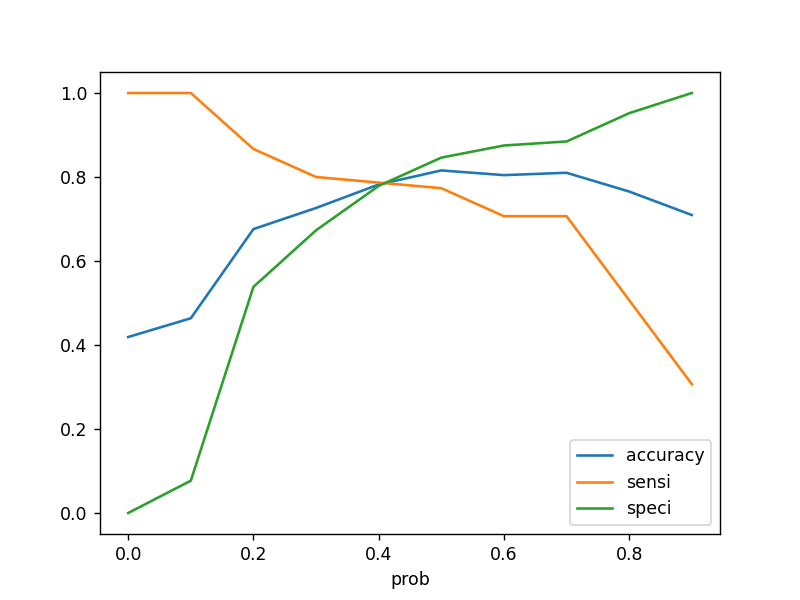

In [46]:
%matplotlib notebook
cutoff_df1.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

Depending upon the use case we can trade of between `accuracy`, `sensitivity` and `specificity`. If we want all of them to be high we will select the intersection point of these curves as our threshold. In this case, threshold will be `0.41`.

In [47]:
preds_th = np.where(best_model.predict_proba(X_train)[:,1] > 0.41, 1, 0)

We will evaluate the metrics for both training and testing sets.

In [48]:
# Calculate accuracy
accuracy = accuracy_score(y_train, preds_th)

# Calculate precision
precision = precision_score(y_train, preds_th)

# Calculate recall
recall = recall_score(y_train, preds_th)

# Calculate F1 score
f1 = f1_score(y_train, preds_th)

roc = roc_auc_score(y_train, preds_th)

# Create a DataFrame to store the results
results_df = pd.DataFrame({'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC'],'Score': [accuracy, f1, precision, recall, roc]})
results_df

,Metric,Score
0,Accuracy,0.773876
1,F1 Score,0.730318
2,Precision,0.660606
3,Recall,0.816479
4,ROC,0.782397


In [49]:
preds_th = np.where(best_model.predict_proba(X_test)[:,1] > 0.41, 1, 0)

In [50]:
# Calculate accuracy
accuracy = accuracy_score(y_test, preds_th)

# Calculate precision
precision = precision_score(y_test, preds_th)

# Calculate recall
recall = recall_score(y_test, preds_th)

# Calculate F1 score
f1 = f1_score(y_test, preds_th)

roc = roc_auc_score(y_test, preds_th)

# Create a DataFrame to store the results
results_df = pd.DataFrame({'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC'],'Score': [accuracy, f1, precision, recall, roc]})
results_df

,Metric,Score
0,Accuracy,0.793296
1,F1 Score,0.761290
2,Precision,0.737500
3,Recall,0.786667
4,ROC,0.792372


Compared to previous model all of the metrics have decreased slightly except `Recall`. `Recall` has increased slightly. So this is how depending upon the business problem we can choose our threshold values.

## Conclusion

In this logistic regression project, we followed a systematic approach to build a predictive model. We started by importing the necessary libraries and loading the data. We then performed data cleaning and preparation, which involved handling missing values, dealing with categorical variables, and scaling the features using techniques such as StandardScaler.

Next, we assessed the multicollinearity among the features using `VIF (Variance Inflation Factor)` to ensure that the predictors were not highly correlated.

We then addressed the issue of class imbalance by adding weights to the classes to give more importance to the minority class during model training. This can help to improve the model's ability to correctly predict the minority class, which may be important in imbalanced datasets.

To optimize the model's performance, we performed hyperparameter tuning, which involved selecting the best hyperparameters for the logistic regression model using `GridSearchCV`. This can help to fine-tune the model and improve its predictive accuracy.

We also evaluated the model's performance using various metrics, such as `ROC curve` and `AUC (Area Under the Curve) score`, which provide insights into the model's ability to correctly classify positive and negative cases.

Furthermore, we used `accuracy`, `sensitivity`, and `specificity` curves to select an optimal threshold for classification based on the specific needs of the project. This allowed us to strike a balance between false positives and false negatives, depending on the costs and consequences of misclassification in the context of the problem being addressed.

It's important to keep in mind that the specific steps and techniques used may vary depending on the dataset, problem, and specific requirements of the project, and further experimentation and fine-tuning may be necessary for the best results.